##  Проект по А/В тестированию

### Цель:

####  Команда внедрила новое решение на сайте — чат с менеджером.
 
 Менеджеры продукта говорят о том, что это вызовет негативный опыт у пользователей, а менеджеры по продажам считают, что так получится больше продавать.
 
  Пришли результаты A/B теста — одной выборке показывали назойливый чат, а другой нет. 
  
  Цель - оцените результаты теста и описать выводы.

In [109]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math as mth

### Изучение и проверка данных:

In [110]:
data= pd.read_csv('ab_log.csv')

In [111]:
data.head()

,event,user_id,EventTime,Group
0,StartReadingOffer,7241586465170049200,1564978321,A2
1,OpenProductCard,4998498972125515821,1564678223,A2
2,StartReadingOffer,5794343176311717876,1564681595,B
3,StartReadingOffer,3371640160394640961,1564635919,A1
4,OpenProductCard,4623191541226589455,1564695060,A1


Описание данных ab_log.csv

event - событие

user_id - id пользователя

EventTime - время события

Group - группа события

Group:

A1 - контрольная группа

A2 - контрольная группа

B - экспериментальная группа

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154788 entries, 0 to 154787
Data columns (total 4 columns):
event        154788 non-null object
user_id      154788 non-null int64
EventTime    154788 non-null int64
Group        154788 non-null object
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


In [113]:
#проверяем таблицу на дубликаты и удаляем их
data.duplicated().sum()
data = data.drop_duplicates()
data.duplicated().sum()

0

In [114]:
# проверяем на пропуски
data.isna().sum()
#data.info()

event        0
user_id      0
EventTime    0
Group        0
dtype: int64

In [115]:
#заменяем названия стлбцов
data.columns=['event_name', 'id', 'event_time', 'exp_id']
data.head()

,event_name,id,event_time,exp_id
0,StartReadingOffer,7241586465170049200,1564978321,A2
1,OpenProductCard,4998498972125515821,1564678223,A2
2,StartReadingOffer,5794343176311717876,1564681595,B
3,StartReadingOffer,3371640160394640961,1564635919,A1
4,OpenProductCard,4623191541226589455,1564695060,A1


In [116]:
#создаем столбец даты и времени
data['event_time_data'] = pd.to_datetime(data['event_time'], unit='s')

In [117]:
#Создаем столбец даты
data['event_data']= data['event_time_data'].dt.strftime('%Y-%m-%d')
data.head(10)

,event_name,id,event_time,exp_id,event_time_data,event_data
0,StartReadingOffer,7241586465170049200,1564978321,A2,2019-08-05 04:12:01,2019-08-05
1,OpenProductCard,4998498972125515821,1564678223,A2,2019-08-01 16:50:23,2019-08-01
2,StartReadingOffer,5794343176311717876,1564681595,B,2019-08-01 17:46:35,2019-08-01
3,StartReadingOffer,3371640160394640961,1564635919,A1,2019-08-01 05:05:19,2019-08-01
4,OpenProductCard,4623191541226589455,1564695060,A1,2019-08-01 21:31:00,2019-08-01
5,StartCheckProduct,7610224088606451298,1564741132,A2,2019-08-02 10:18:52,2019-08-02
6,StartCheckProduct,3313099498687285583,1564750426,A1,2019-08-02 12:53:46,2019-08-02
7,StartReadingOffer,1501908752960545754,1564768055,A2,2019-08-02 17:47:35,2019-08-02
8,StartReadingOffer,4492930508453783534,1564846927,A1,2019-08-03 15:42:07,2019-08-03
9,StartReadingOffer,4733721427754988394,1564939110,A2,2019-08-04 17:18:30,2019-08-04


### Изучение и проверка данных

Сколько всего событий в логе?Сколько всего пользователей в логе?Сколько в среднем событий приходится на пользователя?

In [118]:
event_count = data['event_name'].count()
print('Всего событий в логе',event_count)
user_count = data['id'].nunique()
print('Количество уникальных ползователей:', user_count )
user_count = data.groupby('id').agg({'event_name': 'count'})
print ("В среднем на пользователя приходится событий:", user_count.mean().round())

Всего событий в логе 154492
Количество уникальных ползователей: 6805
В среднем на пользователя приходится событий: event_name    23.0
dtype: float64


#### Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени.

In [119]:
data_min = data['event_data'].min()
data_max = data['event_data'].max()

print("Минимальная дата:", data_min)
print("Максимальная дата:", data_max)

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-05


In [120]:
hist = data.groupby('event_data').agg({'event_name': 'count'}).reset_index()
hist

,event_data,event_name
0,2019-07-25,9
1,2019-07-26,30
2,2019-07-27,56
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,411
6,2019-07-31,2019
7,2019-08-01,36090
8,2019-08-02,35564
9,2019-08-03,33286


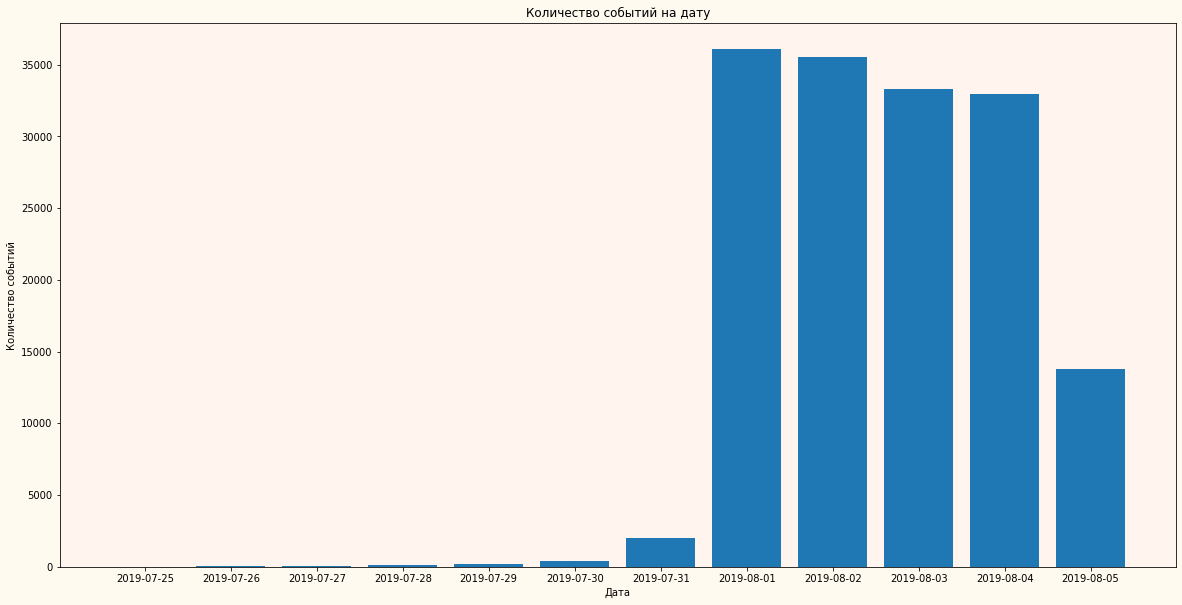

In [121]:
x = hist['event_data']
y = hist['event_name']

fig, ax = plt.subplots()

ax.bar(x, y)
plt.title("Количество событий на дату")
plt.xlabel("Дата")
plt.ylabel("Количество событий")

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(10)    #  высота Figure

plt.show()

Количество событий резко выросло стабилизировалось с 01.08. Обрезаем данные по этой дате

In [122]:
data_new= data.query('event_data >= "2019-08-01"')

Сколько событий и пользователей мы потеряли, отбросив старые данные?


In [123]:
users_lost = (data['id'].nunique() - data_new['id'].nunique()) / data['id'].nunique() * 100
print(users_lost)
event_lost = (data['event_name'].count() - data_new['event_name'].count()) / data['event_name'].count() * 100
event_lost

1.0139603232916972


1.8214535380472776

Обрезав данные мы потеряли 1 % пользователей и 1.8% событий.

 ситаем пользователей из всех трёх экспериментальных групп

In [124]:


data_new['exp_id'].unique()
count_group= data_new.groupby('exp_id').agg({'id': 'nunique'})
count_group

,id
exp_id,
A1,2255
A2,2216
B,2265


Представителей всех трех групп в обрезанной таблице примерно равное количество

### Воронка событий

Посмотрим какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [125]:
event_name = data_new['event_name'].unique()
event_name

array(['StartReadingOffer', 'OpenProductCard', 'StartCheckProduct',
       'OpenPaymentScreen'], dtype=object)

StartReadingOffer- открыл страницу с предложениями по скидкам

OpenProductCard - открыл страницу с товарами

StartCheckProduct - открыл карточку товара

OpenPaymentScreen — открыл окно с оплатой

In [126]:
#частота событий
event_name_frequency = data_new['event_name'].value_counts()
event_name_frequency

StartReadingOffer    72281
StartCheckProduct    29641
OpenProductCard      27334
OpenPaymentScreen    22422
Name: event_name, dtype: int64

Посчитаем сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

In [127]:
#сколько пользователей совершали каждое событие
user_event_count= data_new.groupby('event_name').agg({'id':'nunique'})
user_event_count.reset_index()
user_event_count.sort_values(by = 'id',ascending = False)

,id
event_name,
StartReadingOffer,6592
StartCheckProduct,3972
OpenPaymentScreen,3340
OpenProductCard,3229


In [128]:
#находим общее количество уникальных пользователей
total_user_count = data_new['id'].nunique()
#выводим долю пользователей, которые хоть раз совершали событие
user_part = data_new.groupby('event_name').agg({'id': 'nunique'}).reset_index().sort_values(by = 'id',ascending = False)
user_part['part'] = (user_part['id']/ total_user_count).round(2)
display(user_part)

,event_name,id,part
3,StartReadingOffer,6592,0.98
2,StartCheckProduct,3972,0.59
0,OpenPaymentScreen,3340,0.50
1,OpenProductCard,3229,0.48


Доля уникальных пользователей, совершивших событие, резко падает(почти 40%) от первого события(главная страница) до второго(каталог). С каталога до корзины значително меньше. Из корзины до оплаты доходит подавляющее большинтво.

### Изучаем результаты эксперимента

Сколько пользователей в каждой экспериментальной группе?

In [129]:
#количество пользователей в каждой группе
count_group= data_new.groupby('exp_id').agg({'id': 'nunique'})
count_group

,id
exp_id,
A1,2255
A2,2216
B,2265


In [130]:
#посчитаем сколько пользователей совершили самое популярное событие (StartReadingOffer) в каждой
#из групп
main_user_group_count = data_new.query('event_name == "StartReadingOffer"')
main_user_group_count = main_user_group_count.groupby('exp_id').agg({'id': 'nunique'})  
main_user_group_count.reset_index()
# посчитаем долю пользователей соверивших StartReadingOffer
main_user_group_count['part'] = main_user_group_count['id'] / main_user_group_count['id'].sum()
display(main_user_group_count.round(1))

,id,part
exp_id,,
A1,2206,0.3
A2,2166,0.3
B,2220,0.3


Доля пользовтелей соверивших StartReadingOffer во всех группах примерно равна.

Cоздаем таблицу c количеством пользователей по группам и событиям:

In [131]:
#создаем таблицу c количеством пользователей по группам и событиям
table_test = data_new.pivot_table(index = "exp_id", columns = 'event_name', values = 'id', aggfunc = 'nunique')
#присоединяем столбец с общим числом пользователей по группам
table_test = table_test.join(count_group, on = 'exp_id')
display(table_test)

,OpenPaymentScreen,OpenProductCard,StartCheckProduct,StartReadingOffer,id
exp_id,,,,,
A1,1112,1071,1318,2206,2255
A2,1132,1085,1339,2166,2216
B,1096,1073,1315,2220,2265


Пишем функцию для проверки статистической достоверности отличия групп,используем Z-критерий для провверки равенства долей:

In [132]:
def zfunc(a,b,c,d ):
    alpha = .05 # критический уровень статистической значимости

    purchases = np.array([a, b])
    leads = np.array([c, d])
    # пропорция успехов в первой группе
    p1 = purchases[0]/leads[0]
    # пропорция успехов во второй группе:
    p2 =  purchases[1]/leads[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (purchases[0] + purchases[1])/ (leads[0] +leads[1])
    # ваш код
    difference = p1 - p2
    z_value =difference / mth.sqrt(p_combined * (1 - p_combined) * (1/leads[0] + 1/leads[1]))
                               
    distr = st.norm(0, 1)
    p_value =  (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    if (p_value < alpha): 
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

### Делаем проверку статистической значимости различия групп по событиям:

Делаем А-А тест, сравниваем контрольные группы A1 и A2 по всем событиям:

In [133]:
#сравниваем гуппы A1 и A2 по событию OpenPaymentScreen	
zfunc(1112, 1132, 2255,2216)

p-значение:  0.23651326366316505
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [134]:
#сравниваем гуппы A1 и A2 по событию OpenProductCard	
zfunc(1071, 1085, 2255,2216)

p-значение:  0.3261357129982716
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [135]:
#сравниваем гуппы A1 и A2 по событию StartCheckProduct
zfunc(1318, 1339, 2255,2216)

p-значение:  0.17844987219688857
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [136]:
#сравниваем гуппы A1 и A2 по событию StartReadingOffer	
zfunc(2206, 2166, 2255,2216)

p-значение:  0.8497705060264933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### А-А тест не выявил статастически значимого различия в выборках.

#### Сравниваем по очереди контрольные группы с группой В:

#### A1 и B

In [137]:
#сравниваем гуппы A1 и B по событию OpenPaymentScreen	
zfunc(1112, 1096, 2255,2265)

p-значение:  0.5342996314330497
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [138]:
#сравниваем гуппы A1 и B по событию OpenProductCard	
zfunc(1071, 1073, 2255,2216)

p-значение:  0.5354214216487581
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [139]:
#сравниваем гуппы A1 и B по событию StartCheckProduct
zfunc(1318, 1315, 2255,2265)

p-значение:  0.7900962987501854
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [140]:
#сравниваем гуппы A1 и A2 по событию StartReadingOffer	
zfunc(2206, 2220 , 2255,2265)

p-значение:  0.6609483968688323
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Сравниваем группы A2 и B:


OpenPaymentScreen	OpenProductCard	StartCheckProduct	StartReadingOffer	id
exp_id					
A1	1112	1071	1318	2206	2255
A2	1132	1085	1339	2166	2216
B	1096	1073	1315	2220	2265

In [141]:
#сравниваем гуппы A1 и B по событию OpenPaymentScreen	
zfunc(1132, 1096, 2216,2265)

p-значение:  0.07128877064395422
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [142]:
#сравниваем гуппы A1 и B по событию OpenProductCard	
zfunc(1085, 1073, 2216,2265)

p-значение:  0.2871673884225485
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [143]:
#сравниваем гуппы A1 и B по событию OpenProductCard	
zfunc(1339, 1315, 2216,2265)

p-значение:  0.10697657408290495
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [144]:
#сравниваем гуппы A1 и B по событию StartCheckProduct
zfunc(1339, 1315, 2216,2265)

p-значение:  0.10697657408290495
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [145]:
#сравниваем гуппы A1 и B по событию StartReadingOffer
zfunc(2166, 2220, 2216,2265)

p-значение:  0.5311297624671363
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Выводы :

####   На всех восьми тестах не получилось отвергнуть нулевую гипотезу.

Даже если увеличить уровень критический уровень статистической значимости до 0.1, это не изменит результат.


  Можно с большой долей вероятности утверждать, что наличие чата не влияет на конверсию.
 
 Доля уникальных пользователей, совершивших событие, резко падает(почти 40%) от первого события(главная страница) до второго(каталог). С каталога до корзины значително меньше. Из корзины до оплаты доходит подавляющее большинтво.